# Contour Regularization
This part creates regularized building outlines from the pixel results outputted by the network.

## Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import text
from shapely.geometry import LineString, Point
from shapely.affinity import rotate
from matplotlib import collections  as mc

os.environ["CUDA_VISIBLE_DEVICES"] = ""

%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def f(x):
    return x
interact(f, x=10);

interactive(children=(IntSlider(value=10, description='x', max=30, min=-10), Output()), _dom_classes=('widget-interact',))

## Parameters

In [3]:
# Tolerance for initial douglas-peucker run
approximization_tolerance = 0.01

# All points with a max distance from each other will be added to the same line
point_distance_threshold = 1

# Lines below this length will be discarded
min_points_per_segment = 7

# Angles with a difference up to this value will be considered parallel
angle_parallelity_threshold = 20

# Threshold for the hough-algorithm when finding the lines
hough_lines_threshold = 5

# Lines located at a distance up to this value will be considered neighbours
neighbour_distance_threshold = 10

# Neighbour reassignment: A sliding window will be moved around the contour to detect wrong assignments
# Nr. of segments per window
window_size = 5
# If the probability of a segment to its class is below this threshold, it will be reassigned to the most probable class
reassignment_threshold = 0.25

## Marching Squares
### The marching squares algorithm is used to extract the contour

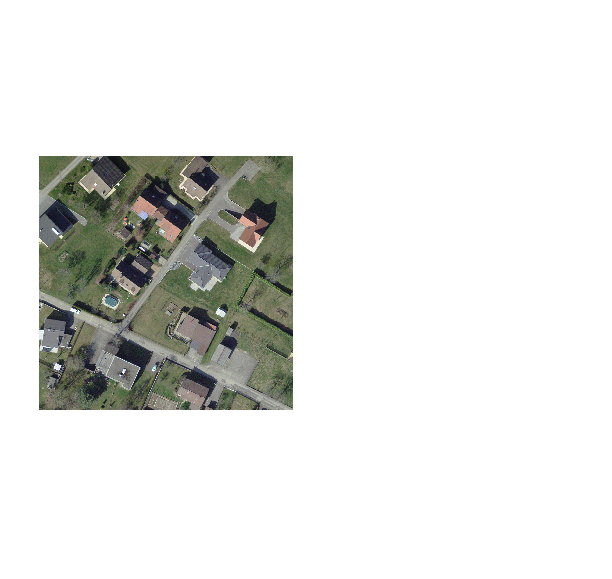

In [9]:
import os

fig, axarr = plt.subplots(1,2, figsize=(10,10))

# p = os.path.join(os.getcwd(), "test", "data", "bigL.bmp")
# p = r"D:\training_images\some_other_city\23128930_15_1_2.tiff"
# p = r"D:\training_images\zurich\17\17_68638_85181.tiff"
# p = r"D:\training_images\rome\17\17_70090_82371.tiff"
# p = r"D:\training_images\zurich_hires\zurich_128_301.tiff"
# p = r"D:\training_images\zurich_hires\zurich_128_305.tiff"
p = r"D:\training_images\_test\DOP10_10cm_LV95_2017.png"
mask_path = p[:-1]
image = plt.imread(p)
if os.path.isfile(mask_path):
    mask = plt.imread(mask_path)
    axarr[1].imshow(mask)
axarr[0].imshow(image)
axarr[0].axis('off')  # clear x- and y-axes
axarr[1].axis('off')
plt.show()

## Create Predictor

In [10]:
from core.predict import Predictor

pedictor = Predictor(os.path.join(os.getcwd(), "model", "mask_rcnn_osm_0076.h5"))

### Predict

In [11]:
point_sets = pedictor.predict_array(image, do_rectangularization=False)

Loading model
Predicting...
Processing 1 images
image                    shape: (1341, 1341, 3)       min:    0.04314  max:    1.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -122.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max: 1341.00000
Prediction done
Extracting contours...
Contours extracted


No handles with labels found to put in legend.


1247


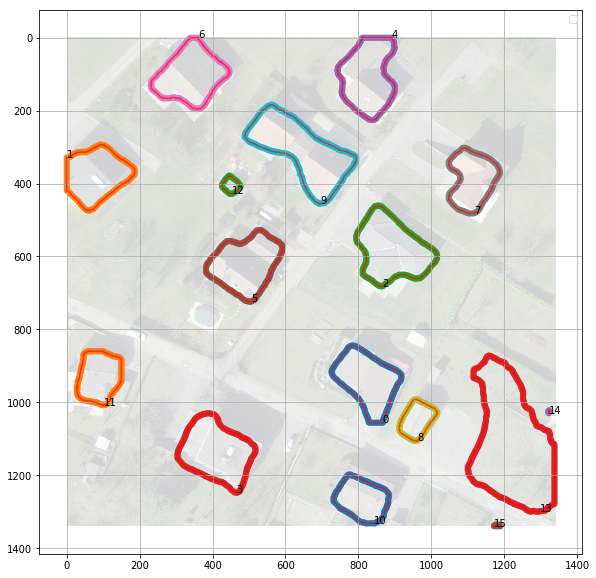

In [12]:
from skimage.measure import approximate_polygon

fig, ax = plt.subplots(figsize=(10,10))
ax.set(aspect='equal')
ax.imshow(image, alpha=0.2)

for i, points in enumerate(point_sets):
    c = approximate_polygon(np.array(points), tolerance=0)
    points = list(map(lambda t: (t[0], t[1]), c.tolist()))

    x = np.asarray(list(map(lambda p: p[0], points)))
    y = np.asarray(list(map(lambda p: p[1], points)))

    ax.scatter(x, y, alpha=0.3, edgecolors='none')
    plt.plot(x, y, color="red", alpha=0.6)
    text(x[0], y[0], "{}".format(i))

points = point_sets[5]
original_points = list(points)
print(len(points))
    
ax.legend()
ax.grid(True)

# plt.gca().invert_yaxis()
plt.show()

## Make lines
Lines will be extracted using a hough-lines algorithm

From 706 points we got 13 line segments.


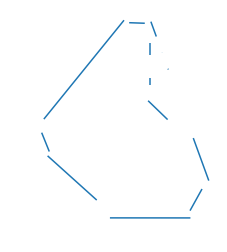

In [173]:
from core.utils import make_lines_new

lines = make_lines_new(points.copy(), 
                       max_point_distance=5, 
                       min_points_per_segment=5, 
                       hough_lines_threshold=5)
print("From {} points we got {} line segments.".format(len(points), len(lines)))

lc = mc.LineCollection(map(lambda l: l.coords, lines))
fig, ax = plt.subplots()
ax.set(aspect='equal')
ax.add_collection(lc)
ax.axis('off')
ax.autoscale()
plt.gca().invert_yaxis()

## The line segments are then group by parallelity and perpendicularity...

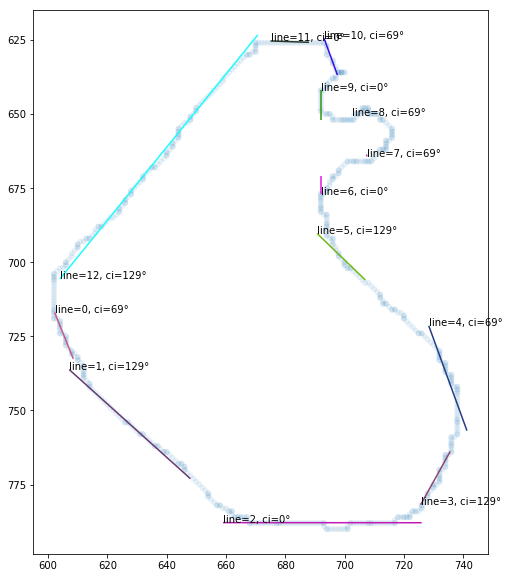

In [174]:
from core.utils import assign_orientation
from itertools import groupby

fig, ax = plt.subplots(figsize=(10,10))
ax.set(aspect='equal')
x = np.asarray(list(map(lambda p: p[0], points)))
y = np.asarray(list(map(lambda p: p[1], points)))
ax.scatter(x, y, alpha=0.1, edgecolors='none')
assign_orientation(lines, angle_parallelity_threshold=angle_parallelity_threshold)
for k, g in groupby(lines, key=lambda l: l.orientation):
    group = list(g)
    colors = np.random.rand(3,)
    for l in group:
        text(l.p1[0], l.p1[1], "line={}, ci={}°".format(l.nr, int(k)))
    lc = mc.LineCollection(map(lambda l: l.coords, group), colors=colors)
    ax.add_collection(lc)
    
ax.autoscale()
plt.gca().invert_yaxis()

## ...and after that, nearest neighbour clusters are created within each group

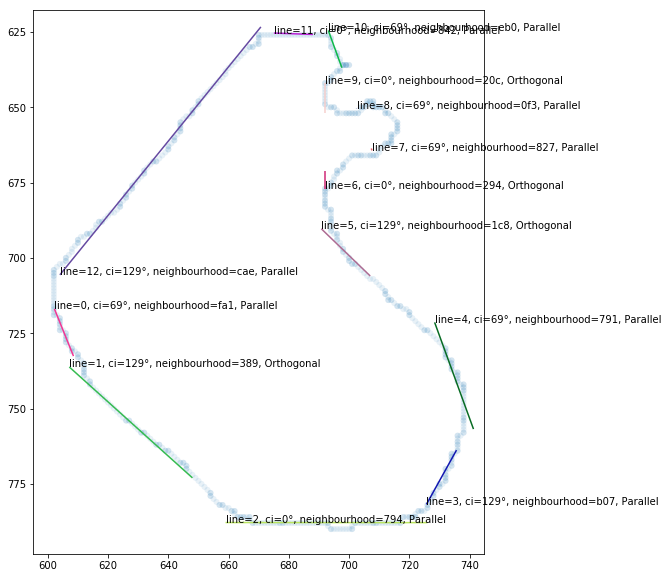

In [175]:
from core.utils import assign_neighbourhood
import copy

fig, ax = plt.subplots(figsize=(10,10))
ax.set(aspect='equal')
ax.scatter(x, y, alpha=0.1, edgecolors='none')

assign_neighbourhood(lines, neighbour_distance_threshold=neighbour_distance_threshold)
grouped = groupby(lines, key=lambda l: l.neighbourhood)
for k, g in grouped:
    group = list(g)
    color = np.random.rand(3,)
    for l in group:
        ori_text = "Orthogonal" if l.orthogonal else "Parallel"
        txt = "line={}, ci={}°, neighbourhood={}, {}".format(l.nr, int(l.orientation), str(k)[:3], ori_text)
        text(l.p1[0], l.p1[1], txt)
    lc = mc.LineCollection(map(lambda l: l.coords, group), colors=color)
    ax.add_collection(lc)
    
    txt = "nr={}, neighbourhood={}".format(group[0].nr, str(group[0].neighbourhood)[:8])

plt.gca().invert_yaxis()
updated_lines = copy.deepcopy(lines)

## Reassignment
### At this point, not all assignments of the lines to an orientation are correct, when seen in spatial context, i.e. their spatial location. A line of orientation _x_ is probably just in outlier, if its neighbours are of orientation _y_. Due to this, we'll reassign a line to another orientation class if necessary.

Additionally, the neighbourhood identifiers will be updated: Up to now, lines with the same orientation class had the same neighbourhood, regardless if they were parallel or perpendicular. Now this distinction will be made and only lines of the same orientation and same parallelity / perpendicularity will share the same neighbourhood.

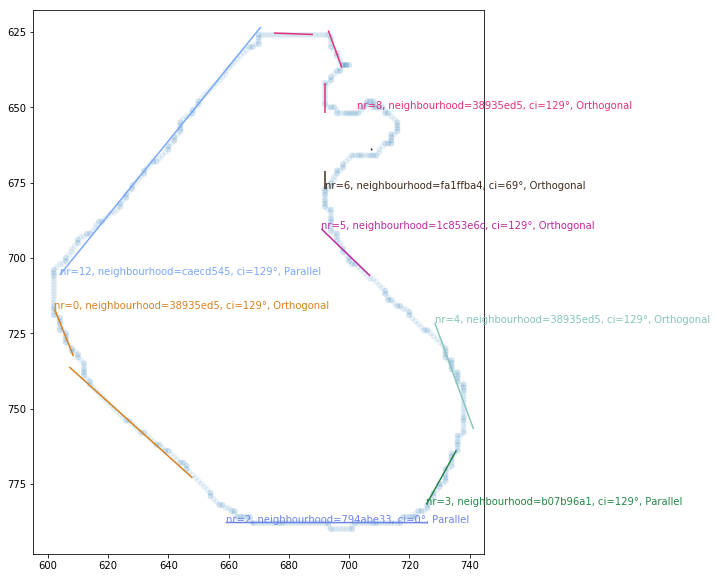

In [176]:
import copy
from core.utils import update_neighbourhoods
from itertools import groupby

updated_lines = copy.deepcopy(lines)
update_neighbourhoods(updated_lines, window_size=window_size, reassignment_threshold=reassignment_threshold)

fig, ax = plt.subplots(figsize=(10,10))
ax.set(aspect='equal')
ax.scatter(x, y, alpha=0.1, edgecolors='none')
grouped = groupby(updated_lines, key=lambda l: l.neighbourhood)
for k, g in grouped:
    line_group = list(g)
    color = np.random.rand(3,)
    lc = mc.LineCollection(map(lambda l: l.coords, line_group), colors=color)
    ax.add_collection(lc)
    
    ori_text = "Orthogonal" if line_group[0].orthogonal else "Parallel"
    txt = "nr={}, neighbourhood={}, ci={}°, {}".format(line_group[0].nr, 
                                                  str(line_group[0].neighbourhood)[:8], 
                                                  int(line_group[0].orientation),
                                                  ori_text)
    text(line_group[0].p1[0], line_group[0].p1[1], txt, color=color)
plt.gca().invert_yaxis()



## Remove redundant segments

5 lines removed. 8 lines left.


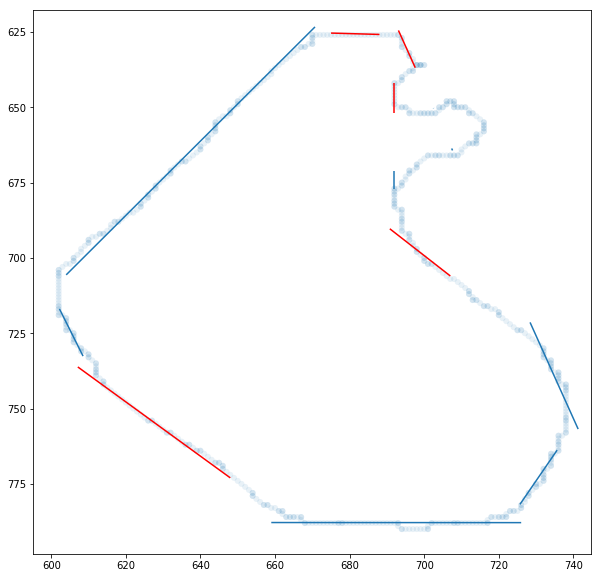

In [177]:
from shapely.affinity import scale

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(x, y, alpha=0.1, edgecolors='none')

i = 0
remove = True
outline = updated_lines
count = 0
removed_lines = []
while i < len(outline):
# for i, line in enumerate(outline):
    line = outline[i%len(outline)]
    next_line = outline[(i+1)%len(outline)]
    parallel = line.orientation == next_line.orientation and line.orthogonal == next_line.orthogonal
    if parallel:
        ls_1 = LineString(line.coords)
        ls_2 = LineString(next_line.coords)
        ls_1_scaled = scale(ls_1, 1000, 1000)
        ls_2_scaled = scale(ls_2, 1000, 1000)
        dist = ls_1_scaled.distance(ls_2_scaled)
        redundant = ls_1_scaled.buffer(1).intersects(ls_2_scaled.buffer(1))
        if redundant:
            outline.remove(next_line)
            count += 1
            removed_lines.append(next_line)
#             print("Line removed: ", line)
        else:
            i += 1
    else:
        i += 1
updated_lines = outline
lc = mc.LineCollection(list(map(lambda l: l.coords, outline)))
removed_lc = mc.LineCollection(list(map(lambda l: l.coords, removed_lines)), color='red')
ax.add_collection(lc)
ax.add_collection(removed_lc)
print("{} lines removed. {} lines left.".format(count, len(updated_lines)))
plt.gca().invert_yaxis()

# Line re-orientation
## Each line is now adjusted to the class orientation it belongs to

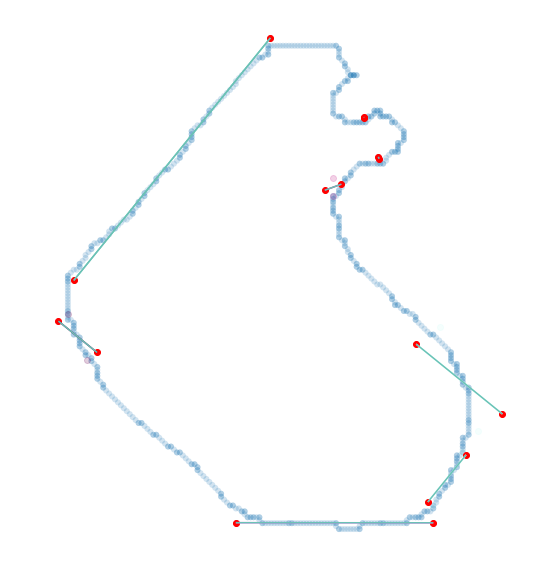

In [178]:
from scipy.optimize import curve_fit
import cv2
import math
from core.utils import get_angle, Line
from shapely.affinity import rotate, scale
from shapely import geometry
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

def make_fit_func(angle: float):
    def fit_line(x, m, b):
        a = angle
        return m * x + b
    return fit_line

fig, ax = plt.subplots(figsize=(10,10))
ax.set(aspect='equal')
ax.scatter(x, y, alpha=0.2, edgecolors='none')

outline = []
grouped_orientation = groupby(updated_lines, key=lambda l: l.orientation)
for k, g in grouped_orientation:
    subgroup = list(g)
    color = np.random.rand(3,)
    for seg in subgroup:
        nr = seg.nr

        current_angle = get_angle((seg.p1, seg.p2))
        if not seg.orthogonal:
            target_angle = k
        else:
            target_angle = (k+90)

        angle_delta = target_angle - current_angle
        angle_delta = min(angle_delta, angle_delta%180)
        ls = rotate(geometry.LineString(seg.coords), angle_delta)

        xs = ls.coords.xy[0]
        ys = ls.coords.xy[1]
        lx = np.asarray(list(map(lambda p: p[0], seg.coords)))
        ly = np.asarray(list(map(lambda p: p[1], seg.coords)))

        fitted_line_new = [(xs[0], ys[0]), (xs[1], ys[1])]
        
        new_line = Line(nr, *fitted_line_new)
        new_line.set_orientation(target_angle)
        outline.append(new_line)
        
        lc = mc.LineCollection([fitted_line_new], colors=color)
        ax.add_collection(lc)
        plt.scatter(lx, ly, color=color, alpha=0.2)        

# This step is important: The points are arranged in CCW order
lines_reordered = [outline.pop()]
while outline:
    line = outline.pop()
    p_1 = min(line.coords, key=lambda p: geometry.Point(p).distance(geometry.Point(lines_reordered[-1].p2)))
    p_2 = line.coords[1] if p_1 == line.coords[0] else line.coords[0]
    next_line = Line(line.nr, p_1, p_2)
    next_line.set_orientation(line.orientation)
    lines_reordered.append(next_line)

outline = lines_reordered
xs = []
ys = []
for l in outline:
    xs.append(l.coords[0][0])
    xs.append(l.coords[1][0])
    ys.append(l.coords[0][1])
    ys.append(l.coords[1][1])
plt.scatter(xs, ys, color='red', alpha=1)  
    
lc = mc.LineCollection(map(lambda l: l.coords, outline), colors=color)
ax.add_collection(lc)
ax.axis('off')
    
plt.gca().invert_yaxis()

# Gap filling
## Now we need to find matching line segments for the gaps.

a) If the two lines already have an intersection point, we're done

b) If two lines are orthogonal to each other:
1. Get the intersection of both lines which results in a single new point which is to be added in between

c) If two lines are parallel:
1. Align a new line orthogonal to the parallel lines with the center of the new line at the center 
2. Find the (projected) intersections between (line_1, new_line) and (line_2, new_line)
3. Adapt both lines: line_1.end = new_line.start, line_2.start = new_line.end
4. The new_line is added inbetween the two lines

In [179]:
from typing import List, Tuple

def _add_coords(geom, coords: List[Tuple[float, float]]) -> None:
    if isinstance(geom, geometry.Point):
        coords.append((geom.x, geom.y))
    elif isinstance(geom, geometry.LineString):
        coords.extend(geom.coords)
    else:
        pass

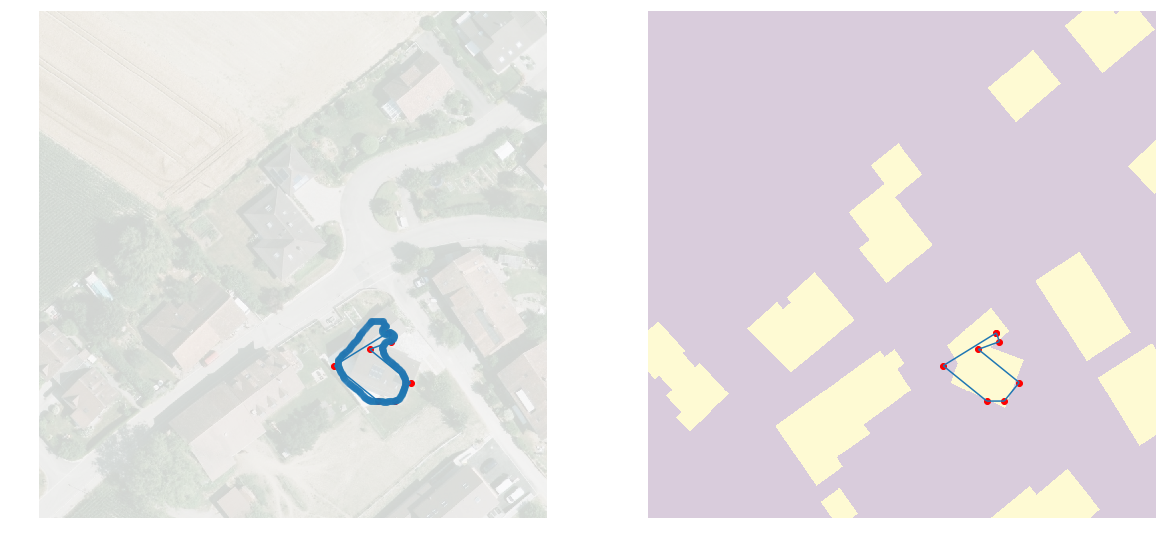

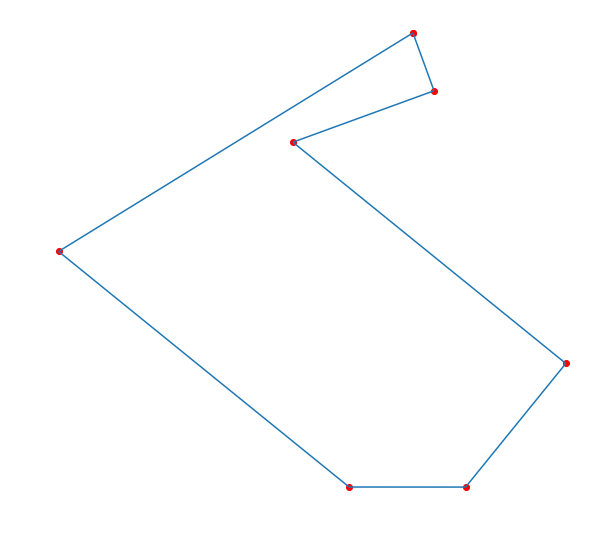

In [180]:
from shapely.affinity import scale, rotate
from core.training_data import get_instances

fig, axarr = plt.subplots(1,2, figsize=(20,20))
_, ax3 = plt.subplots(figsize=(10,10))
ax = axarr[0]
ax2 = axarr[1]
ax.set(aspect='equal')
ax.axis('off')
ax2.set(aspect='equal')
ax2.axis('off')
ax3.set(aspect='equal')
ax3.axis('off')

original_xs = []
original_ys = []


corner_points = []
for i, line in enumerate(outline):
    next_line = outline[(i+1)%len(outline)]
    parallel = line.orientation == next_line.orientation and line.orthogonal == next_line.orthogonal
    ls_1 = LineString(line.coords)
    ls_2 = LineString(next_line.coords)
    original_xs.extend([line.coords[0][0], line.coords[1][0], next_line.coords[0][0], next_line.coords[1][0]])
    original_ys.extend([line.coords[0][1], line.coords[1][1], next_line.coords[0][1], next_line.coords[1][1]])
    if ls_1.intersects(ls_2):
        p = ls_1.intersection(ls_2)
        corner_points.append((p.x, p.y))
    elif parallel:
        ls_1_scaled = scale(ls_1, 1000, 1000)
        ls_2_scaled = scale(ls_2, 1000, 1000)        
        ls_middle = LineString([line.coords[-1], next_line.coords[0]])
        center = ls_middle.centroid
        center_line = scale(rotate(geom=LineString([center, (center.x+10, center.y)]), 
                                   angle=line.orientation+90,
                                   origin=center), 10, 10)

        p_1 = ls_1_scaled.intersection(center_line)
        p_2 = ls_2_scaled.intersection(center_line)
        _add_coords(p_1, corner_points)
        if p_2 != p_1:
            _add_coords(p_2, corner_points)
    else:
        p = scale(ls_1, 1000, 1000).intersection(scale(ls_2, 1000, 1000))
        if isinstance(p, geometry.Point):
            corner_points.append((p.x, p.y))
        elif isinstance(p, geometry.GeometryCollection):
            pass
        
corner_points.append(corner_points[0])
final_lines = []
for idx, p in enumerate(corner_points):
    p_next = corner_points[idx-1]
    final_lines.append((p, p_next))

lc = mc.LineCollection(final_lines)
lc2 = mc.LineCollection(final_lines)
lc3 = mc.LineCollection(final_lines)
ax.add_collection(lc)
ax2.add_collection(lc2)
ax3.add_collection(lc3)
corners_x = np.asarray(list(map(lambda p: p[0], corner_points)))
corners_y = np.asarray(list(map(lambda p: p[1], corner_points)))
ax.scatter(corners_x, corners_y, color='red')
ax2.scatter(corners_x, corners_y, color='red')
ax3.scatter(corners_x, corners_y, color='red')
# ax3.scatter(original_xs, original_ys, alpha=0.5, color="brown")

x = np.asarray(list(map(lambda p: p[0], points)))
y = np.asarray(list(map(lambda p: p[1], points)))
ax.scatter(x, y, alpha=0.2)
# ax2.scatter(x, y, alpha=0.05)

# poly_base = geometry.Polygon(points).buffer(0)
# poly_new = geometry.Polygon(corner_points).buffer(0)
# iou = poly_base.intersection(poly_new).area / poly_base.union(poly_new).area
# print("IoU={}".format(np.round(iou,4)))
plt.gca().invert_yaxis()
ax.imshow(image, alpha=0.2)
ax2.imshow(mask, alpha=0.2)

In [181]:
from core.utils import get_contours
import cv2

mask = cv2.imread(mask_path)
poly_new = geometry.Polygon(corner_points).buffer(0)
poly_new_raw = geometry.Polygon(original_points).buffer(0)
contours = get_contours(mask)
max_iou = 0
max_iou_raw = 0
for c in contours:   
    poly_gt = geometry.Polygon(c).buffer(0)
    iou = poly_gt.intersection(poly_new).area / poly_gt.union(poly_new).area
    iou_raw = poly_gt.intersection(poly_new_raw).area / poly_gt.union(poly_new_raw).area
    if iou > max_iou:
        max_iou = iou
    if iou_raw > max_iou_raw:
        max_iou_raw = iou_raw
print("IoU: {}".format(max_iou))
print("IoU (raw): {}".format(max_iou_raw))

IoU: 0.4874091621406502
IoU (raw): 0.6938097442740815
